In [1]:
import pandas as pd

In [2]:
abt = pd.read_csv("abt/part-00000-f5cbe7a6-d05b-4c21-9e60-9a7fd3ba5cba-c000.csv")

In [3]:
abt.shape

(38708, 111)

In [4]:
abt['date_month'] = pd.to_datetime(abt['date']).dt.strftime('%Y%m').astype("int")

In [5]:
abt['date_month'].value_counts().sort_index()

202401    4355
202402    4105
202403    4505
202404    4381
202405    4347
202406    4168
202407    4374
202408    4320
202409    4153
Name: date_month, dtype: int64

In [6]:
abt.groupby("date_month")['dauReal'].mean()

date_month
202401    434038.283352
202402    446822.165164
202403    460856.888346
202404    463153.561059
202405    464155.812054
202406    462828.279750
202407    461713.207590
202408    471342.845139
202409    475134.945341
Name: dauReal, dtype: float64

#### divisao dos dados entre treino e teste utilizando Out of Time

In [7]:
abt_train = abt[abt['date_month'] <= 202408].copy()
abt_test = abt[abt['date_month'] > 202408].copy()

#### criacao de um dataframe com a média das variaveis na base de treino (para evitar dados de teste no treino), para substituir os dados nulos pela média. Esse dataframe sera salvo na pasta de artefatos, pois para o contexto de produção streaming é impossível calcular a média para os dados, por exemplo se a requisição for feita para consultar o DAU de um único app específico e alguma das variaveis for nula, como a média será calculada? Por isso salvei esse dataframe que contem o valor das médias.

In [ ]:
for i in abt.columns:
    mean_value = avg_df[avg_df['index'] == i]['mean'].values
    if len(mean_value) > 0: 
        abt_train[i] = abt_train[i].fillna(mean_value[0])

In [10]:
avg_df = abt_train.describe().iloc[1,:].reset_index()

In [79]:
avg_df.to_csv("avg_features.csv", index = False)

In [11]:
for i in abt.columns:
    mean_value = avg_df[avg_df['index'] == i]['mean'].values
    if len(mean_value) > 0: 
        abt_train[i] = abt_train[i].fillna(mean_value[0])

In [12]:
abt_train.isna().sum().sort_values()

date                     0
max_45_predictionLoss    0
min_45_predictionLoss    0
avg_45_predictionLoss    0
sum_45_predictionLoss    0
                        ..
avg_15_daily_reviews     0
sum_15_daily_reviews     0
max_90_daily_ratings     0
dauReal                  0
date_month               0
Length: 112, dtype: int64

#### Processo de seleção de variaveis com o Random Forest Regressor para selecionar as variaveis com os maiores valores de Feature Importance

In [13]:
abt_train_fs = abt_train.drop(['date', 'appid', 'category', "date_month"], axis =1)

In [14]:
cols_x_fs = [i for i in abt_train_fs if 'dauReal' not in i]

In [15]:
x_fs = abt_train_fs[cols_x_fs].values
y_fs = abt_train_fs['dauReal'].values

In [16]:
from sklearn.ensemble import RandomForestRegressor

In [17]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=50)

In [18]:
rf_regressor.fit(x_fs, y_fs)

RandomForestRegressor(random_state=50)

In [19]:
feature_importances = rf_regressor.feature_importances_

In [20]:
df_feature_importances = pd.DataFrame({
    "feature": cols_x_fs,
    "importance": feature_importances
    
}).sort_values("importance", ascending=False)

In [21]:
df_feature_importances[0:20]

,feature,importance
1,ratings,0.745890
3,reviews,0.048469
62,max_60_newinstalls,0.045943
58,max_45_newinstalls,0.033191
66,max_90_newinstalls,0.032159
48,avg_15_newinstalls,0.011502
86,max_90_predictionLoss,0.008682
0,category_flag,0.008652
2,daily_ratings,0.008440
106,max_90_diff_install_uninstall,0.003780


#### Eu decidi remover a variavel ratings porque ela estava com um valor de importancia muito discrepante das demais variaveis, em alguns casos o modelo pode ficar instavel.

In [22]:
cols_train = ["appid", "date", "date_month", "dauReal"] + list(df_feature_importances.feature.values[0:20])

In [24]:
cols_train.remove("ratings")

In [28]:
abt_train_01 = abt_train[cols_train]

#### Treinamento dos modelos

#### Optei por usar o pycaret apenas para treinar e fazer o tuning dos hiperparametros e decide não remover os outliers para ter um ambiente mais proximo ao de produção no qual outliers são inevitaveis.

In [29]:
from pycaret.regression import *

In [32]:
regression_setup = setup(data=abt_train_01, target='dauReal', ignore_features=["appid", "date", "date_month"], n_jobs=6,
                         multicollinearity_threshold=0.7)

,Description,Value
0,Session id,4448
1,Target,dauReal
2,Target type,Regression
3,Original data shape,"(34555, 23)"
4,Transformed data shape,"(34555, 20)"
5,Transformed train set shape,"(24188, 20)"
6,Transformed test set shape,"(10367, 20)"
7,Ignore features,3
8,Numeric features,19
9,Preprocess,True


In [33]:
best_model = compare_models(include = ['rf', "lasso", "ridge", "gbr"])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,32858.5359,28598307712.9995,163739.7510,0.9846,0.2783,0.5985,1.7500
gbr,Gradient Boosting Regressor,75558.0736,41626062282.7261,199144.5596,0.9776,1.1279,2.3957,1.8260
ridge,Ridge Regression,227584.6596,249139078230.7788,496740.7671,0.8640,1.8053,9.5711,0.0230
lasso,Lasso Regression,227514.8180,249891744513.9298,497498.2892,0.8636,1.8077,9.5123,0.1020


In [ ]:
tuned_model = tune_model(best_model, n_iter=5, fold=5, optimize='MAE')

In [38]:
tuned_model

RandomForestRegressor(n_jobs=6, random_state=4448)

#### Graficos para analise do modelo

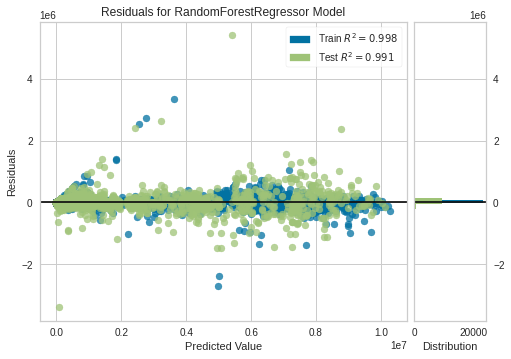

In [43]:
plot_model(tuned_model, plot = 'residuals')

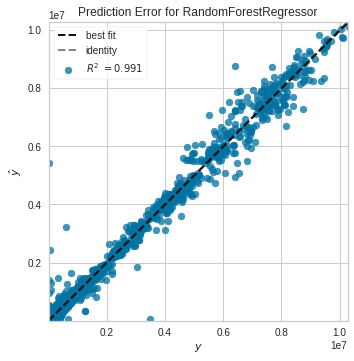

In [51]:
plot_model(tuned_model, plot='error')  

#### Avaliando o modelo comparando a performance na base de treino e de teste

In [53]:
for i in abt_test.columns:
    mean_value = avg_df[avg_df['index'] == i]['mean'].values
    if len(mean_value) > 0: 
        abt_test[i] = abt_test[i].fillna(mean_value[0])

In [ ]:
abt_test_01 = abt_test[cols_train]

#### Performance no treino

In [54]:
scored_train = predict_model(tuned_model, data=abt_train_01)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,17558.9668,7908807610.8809,88931.4771,0.9957,0.2143,0.2855


#### Performance no teste

In [55]:
scored_test = predict_model(tuned_model, data=abt_test_01)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,52575.8134,27606001230.3848,166150.5379,0.9859,0.5904,0.9385


#### Uma analise que achei interessante foi comparar a performace do modelo agrupado pelas categorias. Um dos testes interessante é treinar um modelo separado para as categorias com maiores erros na base de teste pois pode indicar que o publico é diferente dos demais.

In [66]:
dict_ = {1:"FINANCE", 2: "OTHERS", 3: "SHOPPING", 4:"BUSINESS", 5:"TRAVEL_AND_LOCAL", 6:"FOOD_AND_DRINK"}

In [77]:
for i in abt_train_01['category_flag'].value_counts().index:
    abt_test_02 = abt_test_01[abt_test_01['category_flag'] == i]
    abt_train_02 = abt_train_01[abt_train_01['category_flag'] == i]
    
    print("metricas do treino filtrado para a categoria: ", dict_[i])
    scored_train_temp = predict_model(tuned_model, data=abt_train_02)
    
    scored_test_temp = predict_model(tuned_model, data=abt_test_02)
    print()

metricas do treino filtrado para a categoria:  FINANCE


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,24601.3739,12732725832.6447,112839.3807,0.9961,0.1998,0.2201


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,82845.2160,58941421654.1429,242778.5445,0.9833,0.3658,0.2867



metricas do treino filtrado para a categoria:  OTHERS


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,20388.8326,8432373084.3528,91827.9537,0.9952,0.3101,0.7117


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,50189.0026,13565907149.4935,116472.7743,0.9928,0.8869,2.4929



metricas do treino filtrado para a categoria:  SHOPPING


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,8595.4783,3513335965.3040,59273.4001,0.9905,0.1295,0.0735


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,15363.3590,1118338951.5677,33441.5752,0.9946,0.2677,0.1908



metricas do treino filtrado para a categoria:  BUSINESS


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,8770.8388,769705950.6897,27743.5749,0.9947,0.1826,0.1096


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,32874.2519,6976587558.4222,83525.9694,0.9552,0.5873,0.9244



metricas do treino filtrado para a categoria:  TRAVEL_AND_LOCAL


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,1382.0393,28902745.4248,5376.1274,0.9848,0.0926,0.0508


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,16097.5828,1381940316.2230,37174.4578,0.2835,0.9927,1.8066



metricas do treino filtrado para a categoria:  FOOD_AND_DRINK


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,16655.1420,4728991238.6787,68767.6613,0.9674,0.1388,0.0765


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,39221.6939,4177723238.6871,64635.3095,0.9634,0.1351,0.1175


#### Salvando e lendoo modelo

In [88]:
save_model(tuned_model, "model_dau")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['reviews', 'max_60_newinstalls',
                                              'max_45_newinstalls',
                                              'max_90_newinstalls',
                                              'avg_15_newinstalls',
                                              'max_90_predictionLoss',
                                              'category_flag', 'daily_ratings',
                                              'max_90_diff_install_uninstall',
                                              'max_90_daily_ratings',
                                              'predictionLoss',
                                              'max_30_newinstalls',
                                              'avg_30_newin...
                                              'sum_90_newinstalls',
                                              'avg_45_predictionLoss',
    

In [90]:
model = load_model("model_dau")

Transformation Pipeline and Model Successfully Loaded


In [91]:
a=predict_model(model, abt_test_01)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,52575.8134,27606001230.3848,166150.5379,0.9859,0.5904,0.9385


In [92]:
# saving the bases

In [93]:
abt_train_01.to_csv("abt_treino.csv", index=False)

In [94]:
abt_test_01.to_csv("abt_teste.csv", index = False)